In [61]:
# !pip install langgraph

## State

In [62]:
from typing import TypedDict

In [63]:
class State(TypedDict):
    input: str
    assigned_node: str 
    prev_node_to_write: str
    


## Nodes

In [64]:
import random

# Node must be return a dict with the same keys as the State
def bad_manager_node(state: State) -> State:
    node_number = random.randint(1, 2)
    return dict(
        input=state["input"],
        assigned_node="node_" + str(node_number),
        prev_node_to_write="manager",
    )

def node_1(state: State) -> State:
    return dict(
        input=state["input"],
        assigned_node='node_1' if 'node 1' in state['input'].content else 'node_2',
        prev_node_to_write='node_1',
    )

def node_2(state: State) -> State:
    return dict(
        input=state["input"],
        assigned_node='node_2' if 'node 2' in state['input'].content else 'node_1',
        prev_node_to_write='node_2',
    )


## Conditional Edges & Routing Functions

Conditional edges and routing functions, and use the terms interchangeably. I would like to clarify beforehand that a routing function is the python function that contains logic to route the state of the graph to specific nodes.  We can build the conditional edges of our graphs by attaching routing functions to the nodes.

![Workflow 01](https://github.com/dinukasaminda/LangGraph-Lessons/blob/main/workflows_drafts/workflow_01.png?raw=true)



In [65]:
from typing import Literal
from langgraph.graph import END

def bad_manager_node_assigner(state: State) -> Literal['node_1', 'node_2']:
    assigned_node = state["assigned_node"]
    if assigned_node == 'node_1':
        return 'node_1'
    else:
        return 'node_2'

def should_reassing_1(state)-> Literal['node_2', END]:
    assigned_node = state["assigned_node"]
    if assigned_node != 'node_1':
        return 'node_2'
    return END
    
def should_reassing_2(state)-> Literal['node_1', END]:
    assigned_node = state["assigned_node"]
    if assigned_node != 'node_2':
        return 'node_1'
    return END




## Build Graph

In [66]:
from langgraph.graph import StateGraph

workflow = StateGraph(State)

# Add nodes
workflow.add_node("manager", bad_manager_node)
workflow.add_node("node_1", node_1)
workflow.add_node("node_2", node_2)

# Set entry point
workflow.set_entry_point("manager")

# Add edges
workflow.add_conditional_edges(
    "manager",
    bad_manager_node_assigner
)

workflow.add_conditional_edges(
    "node_1",
    should_reassing_1
)

workflow.add_conditional_edges(
    "node_2",
    should_reassing_2
)

graph = workflow.compile()

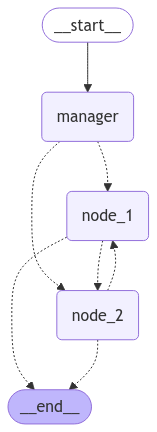

In [67]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)







## Test the graph


In [73]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": 1}}

input = HumanMessage(content="Assign this task to node 1")


for event in graph.stream({
                                "input": input
                            }, config=config):
    print(event)


{'manager': {'input': HumanMessage(content='Assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 'node_2', 'prev_node_to_write': 'manager'}}
{'node_2': {'input': HumanMessage(content='Assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 'node_1', 'prev_node_to_write': 'node_2'}}
{'node_1': {'input': HumanMessage(content='Assign this task to node 1', additional_kwargs={}, response_metadata={}), 'assigned_node': 'node_1', 'prev_node_to_write': 'node_1'}}
